<a href="https://www.kaggle.com/code/yuliashevchenko137/nlp-with-disaster-tweets-eda?scriptVersionId=94828903" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries

In [1]:
#!pip install locationtagger
#!pip install geopy
#!pip install geopandas

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import missingno as msno

import requests, urllib
import re

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import everygrams
from nltk.stem import WordNetLemmatizer

# Import files

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [4]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# 1. Null values

In [5]:
print("The amount of null values: ")
df.isna().sum()

The amount of null values: 


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
print('Total Missing Values: ', df.isna().sum().sum())

Total Missing Values:  2594


<AxesSubplot:>

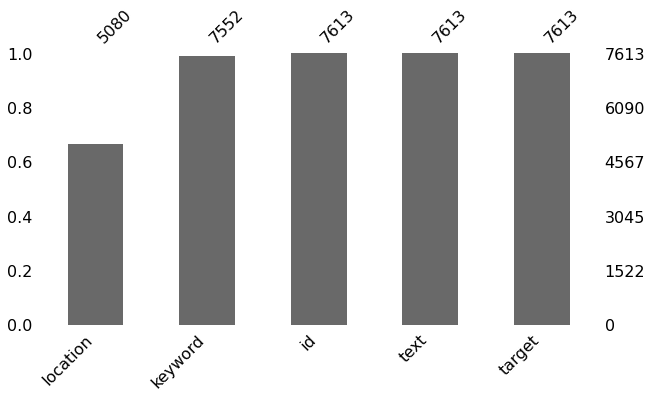

In [7]:
msno.bar(df, sort = "ascending", figsize = (10, 5))

# 2. How balanced the dataset?

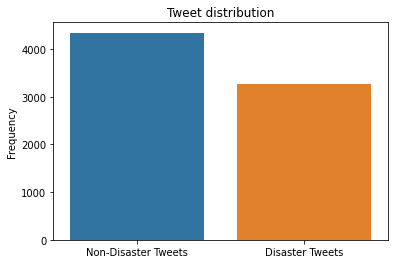

In [8]:
sns.countplot(x = 'target', data = df, linewidth = 1.2)
plt.title("Tweet distribution")
plt.xticks([0,1], ['Non-Disaster Tweets', 'Disaster Tweets'])
plt.xlabel("")
plt.ylabel("Frequency")
plt.show()

In [9]:
df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

The dataset is imbalance (4342 non-disaster tweets and 3271 disaster tweets), so we will need to balance it for further modeling

# 3. How tweets distributed by locations?

In [10]:
df1 = df
df['location'].value_counts()[:20]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: location, dtype: int64

Since we have cases like "USA" abd "United States", we need to clean location column

# Cleaning process

In [11]:
locations = list(df['location'].unique())
locations[locations.index(np.nan)] = "Nan"
sorted(locations);

In [12]:
df1["isKnownLoc"] = (pd.isna(df1["location"]) == False)
df1[df1.isKnownLoc]

,id,keyword,location,text,target,isKnownLoc
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,True
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,True
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,True
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,True
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,True
...,...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0,True
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0,True
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,True
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,True


In [13]:
unknownlocs = {"CLVLND".lower(): "Cleveland",
               "EPTX".lower(): "El Paso, Texas",
               "ChicagoRObotz".lower(): "Chicago",
               "SWMO".lower(): "Southwest Missouri",
               "Selma2Oakland".lower(): "Oakland",
               "BestCoast".lower(): "West Coast",
               "soooota".lower().lower(): "Minnesota",
               "USAoV".lower(): "United States",
               "RhodeIsland".lower(): "Rhode Island",
               "NYHC".lower(): "New York",
               "houstn".lower(): "Houston",
               "NIFC".lower(): "Boise, Idaho",
               "EastCarolina".lower(): "East Carolina",
               "Bhubneshwar".lower(): "Bhubaneswar, India",
               "RedSoxNation".lower(): "Boston",
               "texasss".lower(): "Texas",
               "Flipadelphia".lower(): "Philadelphia",
               "Londonstan".lower(): "London, UK",
               "scumbernauld".lower(): "Cumbernauld, Scotland",
               "L A".lower(): "Los Angeles",
               "IN".lower(): "Indianapolis",
               "MA".lower(): "Massachusetts"}

spam = ["World Wide", "Live On Webcam", "Milky Way", "In Progress", "Your Sister S Bedroom","Instagram", "Global", "We Know",
       "Show", "News And Views", "Y Our", "Out There", "A U S Resident", "With 2 Kids", "Youtube Channel", "Own Zone", "Ig", 
        "ss", "ANYWEHERE", "Blogland", "Earthling For now", "Fakefams", 
        "Live4Heed", "Yooooooo", "WorldWideWeb", "Here", "buhh", "Reddit", "InterplanetaryZone","Hustletown"]
spam = [w.lower() for w in spam]

In [14]:
emailregex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
stop_words = stopwords.words('english')
geolocator = Nominatim(user_agent="My NLP Program")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def location_cleaning(string):
    if pd.isna(string) or re.fullmatch(emailregex, string) or re.match(r"[0-9]+", string):
        return np.nan, np.nan
    #coordinates
    string = re.sub(' +', ' ', re.sub(r",", ", ", string))
    lst = string.split(", ")
    if len(lst) == 2:
        try:
            return float(lst[0]), float(lst[1])
        except ValueError:
            pass
    string = re.sub(' +', ' ', re.sub(r'[^a-zA-Z0-9]', ' ', string))
    lst = [w for w in word_tokenize(string.lower())]
    lst = [w for w in lst if w not in stop_words]
    lst = list(everygrams(lst))
    for tpl in lst[::-1]:
        last_str = (" ".join(tpl)).lstrip(" ").rstrip(" ")
        #print(last_str)
        last_str = unknownlocs.get(last_str, last_str)
        if last_str in spam or last_str == " ": 
            return np.nan, np.nan
        location = geocode(last_str)
        if location is not None:
            return location.latitude, location.longitude
    print(string)
    return np.nan, np.nan

In [15]:
df1['lat'], df1['long'] = zip(*df1.location.apply(location_cleaning))

sindria
Here And There
 
 
 
guaravitas
ducked off 
My contac 27B80F7E 08170156520
IN
 expelcl y
Laventillemoorings 
The below 
 
 
 
MA
 Nxgerxa
Earthling For now 
 t a
we it ixwin
 
Azeroth
Ylisse
Lurking
they her
 he him 
 ForeverWithBAP 8 
GOT7SupportPH
 
 LemonGang 
ARBAILO
 
 
MA
 
 MadeInNorthumberland
 
infj 
 
 
 
 notoriousD12
Halfrica
Here 
 otrakansascity
Here 
 
 
Cydia
 
they them
 
 T 10 614817868480726 12 195582811791382
 
TechFish 
 
Here There
 cockerelshoes
Some where
 
 
 semekeepschanging soyeh 
 
 symbolicjensen 
 
 
 
 
 
westwestwestwestwestwestwest
 BlackLivesMatter
 potteratthedisc
 
 
 9 
Elchilicitanierraversal 
 partsunknown
The Memesphere
Dudetown
 freegucci
 
 
 T 6 488400524109015 3 352798039832285
 
The Internetz
 
 
 
 MayGodHelpUS
ECSU16
Skyhold
 HarleyChick PJNT RunBenRun
 HarleyChick PJNT RunBenRun
 iminchina
Bossland
ON
hkXfYMhEx
with Doflamingo
 OlderCandyBloom 
 
 
Hinterestland
MA
 
they them 
they them 
Soufside
 BossNation 
 PhanTrash
 
 
Nume

In [16]:
new_df = df1[np.isnan(df1.lat) == False]
new_df.head()

,id,keyword,location,text,target,isKnownLoc,lat,long
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,True,52.479699,-1.902691
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,True,51.475245,-2.631816
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,True,11.502434,17.757812
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,True,39.952724,-75.163526
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,True,51.507322,-0.127647


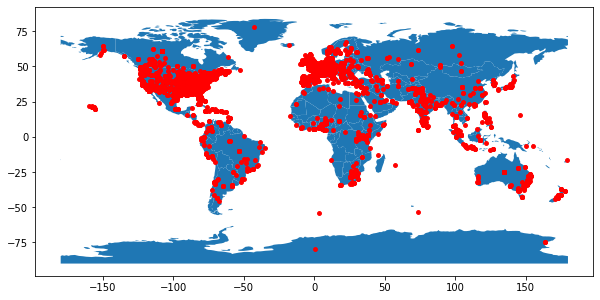

In [17]:
geometry = [Point(xy) for xy in zip(new_df['long'], new_df['lat'])]
gdf = GeoDataFrame(new_df, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

# 4. How do keywords look like?

In [18]:
df1['keyword'].value_counts()[:20]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: keyword, dtype: int64

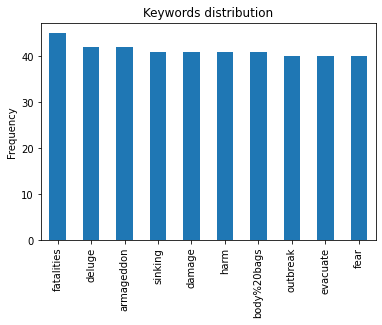

In [19]:
df['keyword'].value_counts().head(10).plot.bar()
plt.title("Keywords distribution")
plt.ylabel("Frequency")
plt.show()

For more precise result, the key words should be lemmatized

In [20]:
lemmatizer = WordNetLemmatizer()

def get_new_keyword(x):
    if pd.isna(x):
        return x
    lst1 = x.split("%20")
    new_str = ''
    if len(lst1) == 1:
        return lemmatizer.lemmatize(x)
    else:
        for l in lst1:
            new_str = new_str + " " + lemmatizer.lemmatize(l)
        return new_str

In [21]:
lemmatizer = WordNetLemmatizer()

df1['new_keyword'] = df1.keyword.apply(get_new_keyword)


In [22]:
df1.new_keyword.value_counts()[:20]

fatality        82
weapon          78
 body bag       74
death           74
injury          71
flood           71
siren           69
casualty        69
hostage         68
 forest fire    51
deluge          42
armageddon      42
harm            41
sinking         41
damage          41
outbreak        40
evacuate        40
fear            40
twister         40
windstorm       40
Name: new_keyword, dtype: int64

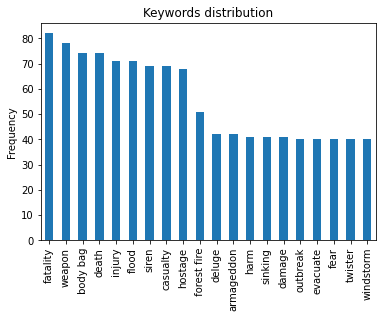

In [23]:
df1['new_keyword'].value_counts().head(20).plot.bar()
plt.title("Keywords distribution")
plt.ylabel("Frequency")
plt.show()

# 5. Tweet specifics

* # Tweet length

In [24]:
df1['tweet_len'] = df1.text.apply(len)
df1

,id,keyword,location,text,target,isKnownLoc,lat,long,new_keyword,tweet_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,False,NaN,NaN,NaN,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,False,NaN,NaN,NaN,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,False,NaN,NaN,NaN,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,False,NaN,NaN,NaN,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,False,NaN,NaN,NaN,88
...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,False,NaN,NaN,NaN,83
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,False,NaN,NaN,NaN,125
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,False,NaN,NaN,NaN,65
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,False,NaN,NaN,NaN,137


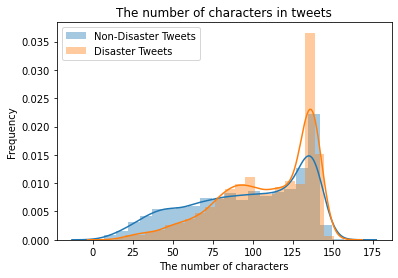

In [25]:
plt.title('The number of characters in tweets')

sns.distplot(df1["tweet_len"][df1.target == 0], label = 'Non-Disaster Tweets')
sns.distplot(df1["tweet_len"][df1.target == 1], label = 'Disaster Tweets')

plt.xlabel('The number of characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* # Number of words

In [26]:
def words_number(str):
    return len(str.split(" "))

df1['word_number'] = df1.text.apply(words_number)

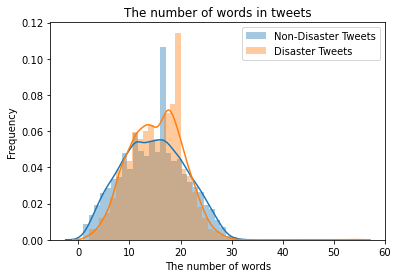

In [27]:
plt.title('The number of words in tweets')

sns.distplot(df1["word_number"][df1.target == 0], label = 'Non-Disaster Tweets')
sns.distplot(df1["word_number"][df1.target == 1], label = 'Disaster Tweets')

plt.xlabel('The number of words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* # Number of mentioning

In [28]:
def count_tags(string):
    return len([tag for tag in string.split() if '@' in tag])

df1['tags_number'] = df1.text.apply(count_tags)

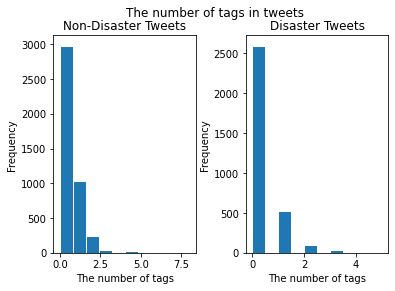

In [29]:
fig, axes = plt.subplots(1, 2)
fig.suptitle('The number of tags in tweets')

axes[0].hist(df1["tags_number"][df1.target == 0], edgecolor = 'white')
axes[0].set_title('Non-Disaster Tweets')
axes[0].set_xlabel('The number of tags')
axes[0].set_ylabel('Frequency')

axes[1].hist(df1["tags_number"][df1.target == 1], edgecolor = 'white')
axes[1].set_title('Disaster Tweets')
axes[1].set_xlabel('The number of tags')
axes[1].set_ylabel('Frequency')

plt.subplots_adjust(wspace = 0.35, hspace = 0.1)
plt.show()

* # Number of hashtags

In [30]:
def count_hashtags(string):
    return len([tag for tag in string.split() if '#' in tag])

df1['hashtags_number'] = df1.text.apply(count_hashtags)

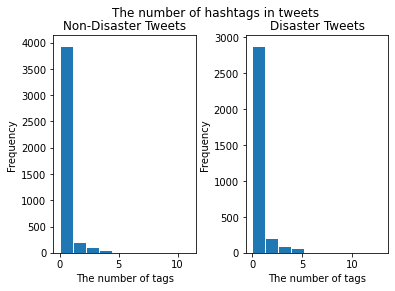

In [31]:
fig, axes = plt.subplots(1, 2)
fig.suptitle('The number of hashtags in tweets')

axes[0].hist(df1["hashtags_number"][df1.target == 0], edgecolor = 'white')
axes[0].set_title('Non-Disaster Tweets')
axes[0].set_xlabel('The number of tags')
axes[0].set_ylabel('Frequency')

axes[1].hist(df1["hashtags_number"][df1.target == 1], edgecolor = 'white')
axes[1].set_title('Disaster Tweets')
axes[1].set_xlabel('The number of tags')
axes[1].set_ylabel('Frequency')

plt.subplots_adjust(wspace = 0.35, hspace = 0.1)
plt.show()

* # Number of URLs

In [32]:
def count_urls(string):
    return len([url for url in string.lower().split() if 'http' in url or 'https' in url or 'www' in url])

df1['url_number'] = df1.text.apply(count_urls)

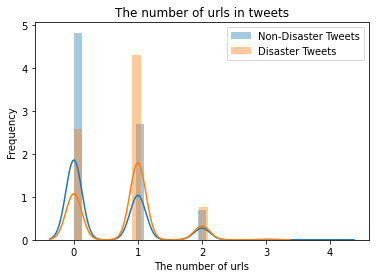

In [33]:
plt.title('The number of urls in tweets')

sns.distplot(df1["url_number"][df1.target == 0], label = 'Non-Disaster Tweets')
sns.distplot(df1["url_number"][df1.target == 1], label = 'Disaster Tweets')

plt.xlabel('The number of urls')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 6. Save the cleared data

In [34]:
df1.head()

,id,keyword,location,text,target,isKnownLoc,lat,long,new_keyword,tweet_len,word_number,tags_number,hashtags_number,url_number
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,False,NaN,NaN,NaN,69,13,0,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,False,NaN,NaN,NaN,38,7,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,False,NaN,NaN,NaN,133,22,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,False,NaN,NaN,NaN,65,9,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,False,NaN,NaN,NaN,88,17,0,2,0


In [35]:
new_df = df1[['lat', 'long', 'new_keyword', 'word_number', 'tags_number','hashtags_number','url_number', 'text', 'target']]
new_df.head()

,lat,long,new_keyword,word_number,tags_number,hashtags_number,url_number,text,target
0,NaN,NaN,NaN,13,0,1,0,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,NaN,7,0,0,0,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,NaN,22,0,0,0,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,NaN,9,0,1,0,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,NaN,17,0,2,0,Just got sent this photo from Ruby #Alaska as ...,1


In [36]:
new_df.lat[pd.isna(new_df.lat)] = 360.0
new_df.long[pd.isna(new_df.long)] = 360.0
new_df.new_keyword[pd.isna(new_df.new_keyword)] = ''
new_df.head()

,lat,long,new_keyword,word_number,tags_number,hashtags_number,url_number,text,target
0,360.0,360.0,,13,0,1,0,Our Deeds are the Reason of this #earthquake M...,1
1,360.0,360.0,,7,0,0,0,Forest fire near La Ronge Sask. Canada,1
2,360.0,360.0,,22,0,0,0,All residents asked to 'shelter in place' are ...,1
3,360.0,360.0,,9,0,1,0,"13,000 people receive #wildfires evacuation or...",1
4,360.0,360.0,,17,0,2,0,Just got sent this photo from Ruby #Alaska as ...,1


In [37]:
new_df.to_csv('/kaggle/working/cleaned_train.csv')